# TabNet For Glaucoma Surgery Prediction
Model construction, training, hyperparameter tuning, and evaluation for the TabNet Fusion Model. The same process was applied for TabNet single modality model training and evaluation as well. 

In [1]:
# Imports
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

### Import Data

In [2]:
column_order = ['pat_mrn', 'target', 'bcvalogmarod_best', 'bcvalogmarod_worst',
       'bcvalogmarod_med', 'bcvalogmarod_last', 'bcvalogmaros_best',
       'bcvalogmaros_worst', 'bcvalogmaros_med', 'bcvalogmaros_last', 'todlo',
       'todhi', 'todmed', 'todlast', 'toslo', 'toshi', 'tosmed', 'toslast',
       'cctodlast', 'cctoslast', 'spheqvod', 'spheqvos', 'agestd', 'enc_sex_F', 'enc_race_ASIAN',
       'enc_race_BLACK', 'enc_race_DECLINES_TO_STATE', 'enc_race_HISPANIC',
       'enc_race_OTHER', 'average_rnfl_thickness_OD',
       'average_rnfl_thickness_OS', 'Rim_Area_OD', 'Rim_Area_OS',
       'Disc_Area_OD', 'Disc_Area_OS', 'Average_CD_Ratio_OD',
       'Average_CD_Ratio_OS', 'Vertical_CD_Ratio_OD', 'Vertical_CD_Ratio_OS',
       'Cup_Volume_OD', 'Cup_Volume_OS', 'S_OD', 'S_OS', 'T_OD', 'T_OS',
       'N_OD', 'N_OS', 'I_OD', 'I_OS']

# Fusion Data
rnflehr_train = pd.read_csv('data_updated/rnflehr_train_arvo.csv')
rnflehr_val = pd.read_csv('data_updated/rnflehr_val_arvo.csv')
rnflehr_test = pd.read_csv('data_updated/rnflehr_test_arvo.csv')

rnflehr_train = rnflehr_train[column_order]
rnflehr_val = rnflehr_val[column_order]
rnflehr_test = rnflehr_test[column_order]

# Note: For single modality models, import the respective data instead

In [3]:
dataset_name = 'fusion'

In [4]:
# RNFL + EHR
train_data = rnflehr_train.copy()
val_data = rnflehr_val.copy()
test_data = rnflehr_test.copy()

In [5]:
# TabNet takes the .values of pandas dataframes
X_train = train_data.drop(columns=['pat_mrn', 'target']).values
y_train = train_data.target.values

X_valid = val_data.drop(columns=['pat_mrn', 'target']).values
y_valid = val_data.target.values

X_test = test_data.drop(columns=['pat_mrn', 'target']).values
y_test = test_data.target.values

### Setting up Model Parameters and Feature Grouping

In [6]:
grouped_features = [[21,22,23,24,25,26]] # Grouping the demographics feature fusion model

In [1]:
# Use these features later for the explainability mask plots
features = [ col for col in train_data.drop(columns=['pat_mrn', 'target']).columns]  

In [9]:
# Fusion Model Params 
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2), 
                 "scheduler_params":{"step_size": 25, 
                                 "gamma":0.9}, 
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR, 
                 "mask_type":'entmax', 
                 "grouped_features" : grouped_features 
                }  

clf = TabNetClassifier(**tabnet_params 
                      )

/opt/conda/envs/bert-pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/jupyter/.local/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [10]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [11]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.3) 

### Train the model

In [2]:
save_history = [] 

for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        eval_name=['train', 'valid'], 
        eval_metric=['auc'], 
        max_epochs=max_epochs , patience=20, 
        batch_size=128, virtual_batch_size=32, 
        num_workers=0, 
        weights=1,
        drop_last=False, 
        augmentations=aug, #aug, None
        compute_importance=True, # True by default so not needed
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

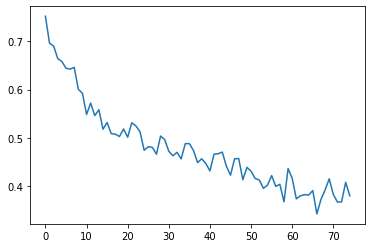

In [13]:
# REDO THIS ONE plot losses for RNFL EHR only 
plt.plot(clf.history['loss'])

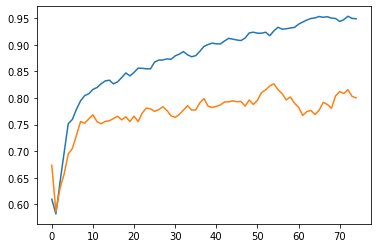

In [14]:
# AUCs
plt.plot(clf.history['train_auc']) 
plt.plot(clf.history['valid_auc']) 

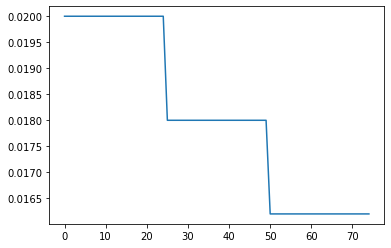

In [15]:
# Learning rate
plt.plot(clf.history['lr'])

In [3]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

In [18]:
# Find optimal threshold using validation set

best_threshold = 0.5  # Starting threshold

best_f1_score = 0
optimal_threshold = best_threshold

yval_probs = clf.predict_proba(X_valid)

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_thresholded = (yval_probs[:, 1] > threshold).astype(int)
    f1 = f1_score(y_valid, y_pred_thresholded)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1 Score:", best_f1_score)

Optimal Threshold: 0.5
Best F1 Score: 0.578125


In [19]:
# Classification report for test set

# Get the probabilities for the positive class
y_pred_probs_test = clf.predict_proba(X_test)[:, 1]

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
roc_auc = roc_auc_score(y_test, y_pred_probs_test)

# Generate Classification Report
y_pred_thresholded = (y_pred_probs_test > optimal_threshold).astype(int)
report = classification_report(y_test, y_pred_thresholded, digits=3)
print(f"Classification Report for XGB on Test Set:")
print(report)

Classification Report for XGB on Test Set:
              precision    recall  f1-score   support

           0      0.903     0.776     0.835       192
           1      0.494     0.724     0.587        58

    accuracy                          0.764       250
   macro avg      0.699     0.750     0.711       250
weighted avg      0.808     0.764     0.777       250



In [20]:
# Get up to 3 decimal places for classification metrics

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Assuming 'y_test' and 'y_pred_probs_test' are defined
y_pred_thresholded = (y_pred_probs_test > optimal_threshold).astype(int)

# Compute precision, recall, f1-score, and support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_thresholded, average='binary')

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
roc_auc = roc_auc_score(y_test, y_pred_probs_test)

# Format and print the results
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")


ROC AUC: 0.832
Precision: 0.494
Recall: 0.724
F1-score: 0.587


## Overall Feature Importances 
TabNet provides access to a ranking of features in terms of their overall performance; this is overall feature importance.

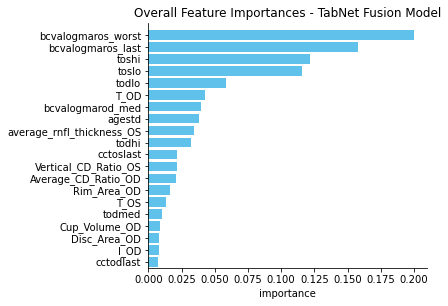

In [27]:
feat_importances = clf.feature_importances_
indices = np.argsort(feat_importances)
fig, ax = plt.subplots(figsize=(5, 4.5))

# Remove box border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title("Overall Feature Importances - TabNet Fusion Model")
plt.xlabel('importance')  # Set x-label
plt.barh(range(len(feat_importances)), feat_importances[indices],color="#60c1eb", align="center")
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])

# Top 25 features
plt.ylim([len(feat_importances)-20.5, len(feat_importances)])
# plt.savefig('plots_updated/tabnet_overall_feat_importance.png', bbox_inches='tight')  
plt.show();

## Instance-wise Feature Importance
TabNet also allows us to inspect the importance of each of the features for each of the individual rows.

In [4]:
!pip install plotly

In [5]:
import numpy  as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import plotly.express as px

!pip install -q pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor

!pip install -q datatable 
import datatable as dt

import torch

In [62]:
explainability_matrix , masks = clf.explain(X_test)

# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
val_preds = clf.predict(X_test)

explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])

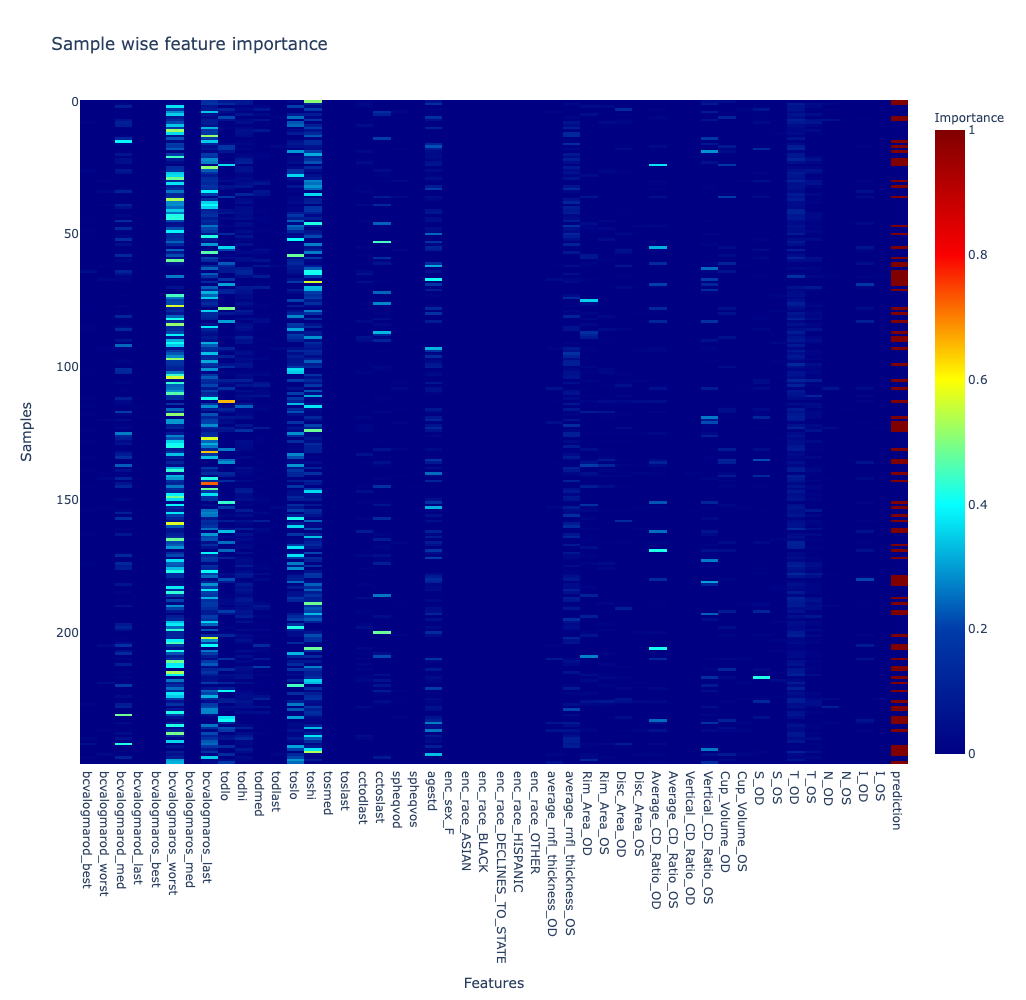

In [85]:
px.imshow(explain_and_preds[:,:],
          labels=dict(x="Features", y="Samples", color="Importance"),
          x=features+["prediction"],
          title="Sample wise feature importance",
          color_continuous_scale='Jet',
          height=1000,
          width=1000)